# Recommendation & Accuracy 

GOALS:::

Recommendation Strategies
1. k constant: recommend with k many papers
2. k parameter: threshold on the papers

Evaluation Strategies
1. Accuracy metrics
2. Discovery-oriented metrics
"""


# Example

In [3]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../../')
import random
import preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from collections import defaultdict
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
from surprise import SVD, SVDpp, NMF
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate,  KFold


### Below tic toc from https://stackoverflow.com/questions/5849800/tic-toc-functions-analog-in-python
import time
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

###all rights to below for these functions
###http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls




# Recommendation System
## 1. Un-Normalized Case.
### 1.1 Regularization Hyperparameter search


In [2]:
"""
Un-Normalized Case.
"""

random_dict = preprocess.create_random_subset_user_paper_data(debug=True)
rating_scale = (1,11)
trainset, testset = preprocess.user_paper_train_test_split(random_dict, test_size = .2)
trainset = preprocess.create_surprise_user_paper_data(trainset, rating_scale).build_full_trainset()
testset = preprocess.create_surprise_user_paper_data(testset, rating_scale).build_full_trainset().build_testset()


# data = preprocess.create_surprise_user_paper_data(random_dict,rating_scale)
# trainset, testset = train_test_split(data, test_size=.25)
# algo = SVD(biased=False, n_epochs = 100)
# algo.fit(trainset)
# predictions = algo.test(testset,clip=False)
# df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])


In [5]:
# Regularization Hyperparameter Search 1.
lambdas = 10.0**np.arange(-7,3)
test_loss_possible_rmse = np.zeros(len(lambdas))
test_loss_all_rmse = np.zeros(len(lambdas))
test_loss_possible_mae = np.zeros(len(lambdas))
test_loss_all_mae = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    algo = SVD(biased=False, n_epochs = 100,reg_all=lambdas[i])
    algo.fit(trainset)
    predictions = algo.test(testset, clip=False)
    possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    test_loss_possible_rmse[i] = accuracy.rmse(possible_predictions)
    test_loss_all_rmse[i] = accuracy.rmse(predictions)
    test_loss_possible_mae[i] = accuracy.mae(possible_predictions)
    test_loss_all_mae[i] = accuracy.mae(predictions)
    
    
# df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

hihihihihihi
RMSE: 1.0537
RMSE: 0.8594
MAE:  0.9844
MAE:  0.6615
hihihihihihi
RMSE: 1.0552
RMSE: 0.8607
MAE:  0.9870
MAE:  0.6632
hihihihihihi
RMSE: 1.0562
RMSE: 0.8614
MAE:  0.9892
MAE:  0.6646
hihihihihihi
RMSE: 1.0518
RMSE: 0.8580
MAE:  0.9850
MAE:  0.6619
hihihihihihi
RMSE: 1.0534
RMSE: 0.8593
MAE:  0.9865
MAE:  0.6629
hihihihihihi
RMSE: 1.0456
RMSE: 0.8530
MAE:  0.9846
MAE:  0.6617
hihihihihihi
RMSE: 1.0265
RMSE: 0.8378
MAE:  0.9820
MAE:  0.6599
hihihihihihi
RMSE: 1.0675
RMSE: 0.8705
MAE:  1.0407
MAE:  0.6981
hihihihihihi
RMSE: 1.0704
RMSE: 0.8728
MAE:  1.0436
MAE:  0.7000
hihihihihihi
RMSE: 1.0704
RMSE: 0.8728
MAE:  1.0436
MAE:  0.7000


In [54]:
# lambda = 10^-1 works best for all four accuracies.
# Set reg_all = 10^-1
# Now let's do precision and recall.
algo = SVD(biased=False, n_epochs = 100,reg_all=10**(-1))
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
possible_predictions = [predictions[idx] for idx in range(len(predictions)) if predictions[idx].details['was_impossible']==False]
    

hihihihihihi


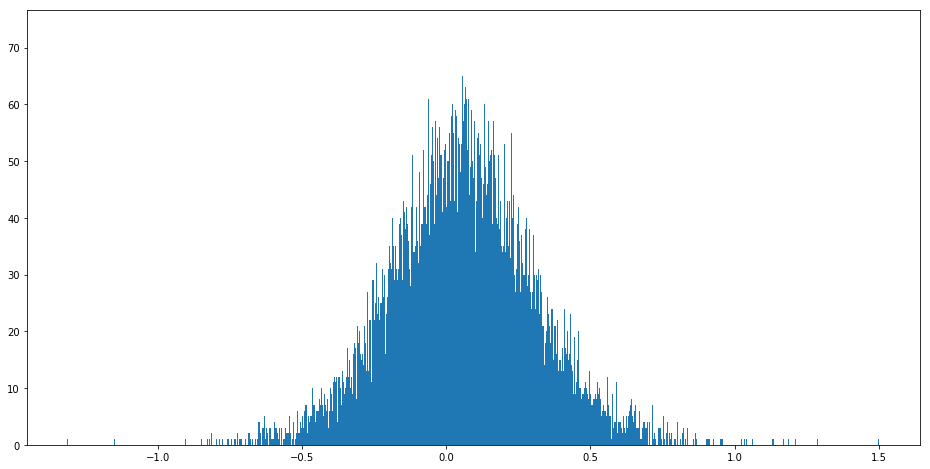

(0.058535069763064863, 0.25363236414386225, 1.5003439834864005)

In [66]:
"""
Estimation is a gaussian distribution.
Below is a histogram of estimations.
"""
estimations = []
for idx in range(len(possible_predictions)):
    estimations.append(possible_predictions[idx].est)

plt.hist(estimations,bins=1000)
plt.show()

np.mean(estimations),np.std(estimations),max(estimations)


### 1.2 Precision and Recall


In [74]:
# top_n_all = get_top_n(predictions, n=k)
# top_n_possible = get_top_n(possible_predictions, n=k)
# # Print the recommended items for each user
# for uid, user_ratings in top_n_possible.items():
#     print(uid, [iid for (iid, _) in user_ratings], '\n')

k = 20
threshold = 0

precisions_all, recalls_all = precision_recall_at_k(predictions, k=k, threshold=threshold)
precisions_possible, recalls_possible = precision_recall_at_k(possible_predictions, k=k, threshold=threshold)

# Precision and recall can then be averaged over all users
print('Precision for all:   '+str(sum(prec for prec in precisions_all.values()) / len(precisions_all)))
print('Recall for all:      '+str(sum(rec for rec in recalls_all.values()) / len(recalls_all)))
print('Precision for possible:   '+str(sum(prec for prec in precisions_possible.values()) / len(precisions_possible)))
print('Recall for possible:      '+str(sum(rec for rec in recalls_possible.values()) / len(recalls_possible)))

Precision for all:   0.992842535787
Recall for all:      0.711353160904
Precision for possible:   0.90684508492
Recall for possible:      0.58508776762
